In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.sparse import coo_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def eucl_dist(x,y):
    return np.sqrt(np.sum(np.square(x-y)))    

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [3]:
## load data
train_mat = loadmat('/home/bsong/kaggle_uci/kaggle77b_trainset.mat')
test_mat = loadmat('/home/bsong/kaggle_uci/kaggle77b_testset.mat')

## convert to numpy array
train = np.array(train_mat['trainset'])
test = np.array(test_mat['testset'])

## redefine some things to better work with
train[train==99] = np.NaN
test[test==99] = np.NaN

coor_test_pred_vals = np.where(test == 55)
test[test==55] = np.NaN

## make sure there are no empty columns or empty rows

print('any columns completely blank: ' + str((train == np.NaN).all(axis=0).any()))
print('any rows completely blank: ' + str((train == np.NaN).all(axis=1).any()))

any columns completely blank: False
any rows completely blank: False


In [5]:
comb_mats = np.concatenate((train,test), axis = 0)
comb_mats.shape

(24983, 100)

In [6]:
tr_conv = ((comb_mats + 10) / 20) + 1
tr_conv = np.nan_to_num(tr_conv)

In [47]:
def my_timer(function_):
    import time
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = function_(*args,**kwargs)
        time_taken = time.time() - start_time
        print('{}() ran in: {} seconds.'.format(function_.__name__, time_taken))
        return result
    return wrapper

@my_timer
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        
    @my_timer
    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 5 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
    
    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    
    


In [48]:
mf = MF(tr_conv, K=10, alpha=0.1, beta=0.01, iterations=20)

MF() ran in: 5.96046447754e-06 seconds.


In [49]:
mf.train()

Iteration: 5 ; error = 257.1262
Iteration: 10 ; error = 242.2303
Iteration: 15 ; error = 237.1415
Iteration: 20 ; error = 238.6172
train() ran in: 505.092225075 seconds.


[(0, 282.0320347810512),
 (1, 277.84620317410673),
 (2, 268.99192848287913),
 (3, 263.6308775887663),
 (4, 257.12616778262554),
 (5, 251.82655193212148),
 (6, 251.28235953228437),
 (7, 246.12078843579158),
 (8, 243.35379186669093),
 (9, 242.23028432704604),
 (10, 240.4242893778077),
 (11, 240.39199465029765),
 (12, 237.75525103856347),
 (13, 238.38817547978175),
 (14, 237.14152662509534),
 (15, 237.75969806861238),
 (16, 237.56188264563872),
 (17, 237.62067904754934),
 (18, 237.53732004819105),
 (19, 238.61718784655454)]

In [56]:
a = (((mf.full_matrix() - 1)*20) - 10).round(2); a

array([[ -5.17,  -6.41, -10.03, ...,  -5.05,  -6.53,  -7.22],
       [  1.03,  -0.88,   6.55, ...,   1.04,   2.3 ,   5.08],
       [  7.44,   5.61,   8.32, ...,   5.75,   7.64,   7.31],
       ...,
       [  0.06,  -2.94,   8.83, ...,  -2.88,  -0.06,   3.96],
       [ -1.97,  -0.44,  -2.17, ...,  -0.31,  -2.69,   0.4 ],
       [  1.2 ,   1.62,  -0.77, ...,   1.69,   0.02,   0.68]])

In [54]:
train

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [ 9.13, -8.16,  8.59, ..., -8.59,  9.13,  8.45],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [58]:
tr2 = np.nan_to_num(train)
dist = a[tr2 != 0] - tr2[tr2!=0]


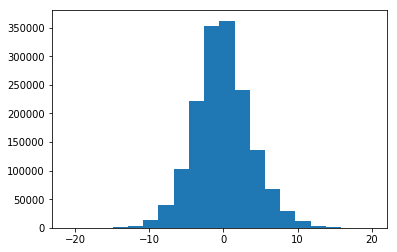

In [60]:
import matplotlib.pyplot as plt

plt.hist(dist, bins = 20)
plt.show()

In [62]:
mf.P.shape

(21983, 10)

In [63]:
mf.Q.shape

(100, 10)

In [70]:
corr_test = cosine_similarity(np.nan_to_num(test),np.nan_to_num(train))
corr_test.shape

(3000, 21983)

In [84]:
simil_inds = [corr_test[i,np.squeeze(np.argsort(-corr_test[i,:]))[200]] for i in range(corr_test.shape[0])] 

In [98]:
new_arr = np.zeros(corr_test.shape)
for i in range(corr_test.shape[0]):
    a = corr_test[i,:]
    a[a >= simil_inds[i]] = 1
    a[a < simil_inds[i]] = 0
    new_arr[i,:] = a
    
    

In [102]:
guesses = np.matmul(corr_test, mf.P) / len(simil_inds)
guesses = np.matmul(guesses, np.transpose(mf.Q))


In [104]:
np.max(guesses)

0.017547461935850984